## Libraries

In [4]:
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from gplearn.fitness import make_fitness

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
import pickle

In [9]:
import cufflinks as cf
cf.go_offline()

In [10]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
%run ..\..\Data\triangulars.ipynb

## Functions

### Gplearn functions

In [12]:
# custom metric
def _mape(y, y_pred, w):
    diffs = np.abs(np.divide((np.maximum(0.001, y) - np.maximum(0.001, y_pred)),np.maximum(0.001, y)))
    
    return 100. * np.average(diffs, weights=w)

mape = make_fitness(_mape, greater_is_better=False)

In [13]:
def _cos_7(x1):
    return np.cos(2*np.pi*(x1/7))
    
cos_7 = make_function(function=_cos_7,
                        name='cos_7',
                        arity=1)

def _sin_7(x1):
    return np.sin(2*np.pi*(x1/7))
    
sin_7 = make_function(function=_sin_7,
                        name='sin_7',
                        arity=1)

In [14]:
def _cos_365(x1):
    return np.cos(2*np.pi*(x1/365))
    
cos_365 = make_function(function=_cos_365,
                        name='cos_365',
                        arity=1)

def _sin_365(x1):
    return np.sin(2*np.pi*(x1/365))
    
sin_365 = make_function(function=_sin_365,
                        name='sin_365',
                        arity=1)

In [15]:
def _cos_372(x1):
    return np.cos(2*np.pi*(x1/372))
    
cos_372 = make_function(function=_cos_372,
                        name='cos_372',
                        arity=1)

def _sin_372(x1):
    return np.sin(2*np.pi*(x1/372))
    
sin_372 = make_function(function=_sin_372,
                        name='sin_372',
                        arity=1)

In [16]:
def abscos_14(x1):
    return np.abs(np.cos(2*np.pi*(x1/14)))
    
abscos_14 = make_function(function=abscos_14,
                        name='abscos_14',
                        arity=1)

def abssin_14(x1):
    return np.abs(np.sin(2*np.pi*(x1/14)))
    
abssin_14 = make_function(function=abssin_14,
                        name='abssin_14',
                        arity=1)

In [17]:
def one(x1):
    return np.ones(len(x1))

one = make_function(function = one, 
                    name = 'one', 
                    arity = 1)

In [18]:
def time(x1):
    return np.arange(1, len(x1)+1)

time = make_function(function = time,
                    name = 'time',
                    arity = 1)

### model functions

In [19]:
def residual_(X, y, model):
    # scale data
    X_train, X_test, y_train, y_test = train_test_split(X, consumo, test_size = 365, shuffle = False)
    scaler1 = MaxAbsScaler(); scaler1.fit(y_train)
    y_train = scaler1.transform(y_train).reshape(-1) 
    y_test = scaler1.transform(y_test).reshape(-1)
    # fit linear regression
    run = LinearRegression().fit(X_train, y_train)
    y_res_tr = run.predict(X_train)
    y_res_te = run.predict(X_test)
    # join forecasting and train prediction
    y_res = np.hstack([y_res_tr, y_res_te])
    # predict with loaded model
    y_pred = model.predict(X) + y_res
    y_pred = scaler1.inverse_transform(y_pred.reshape(-1, 1))
    plotting = pd.DataFrame(y_pred, index = consumo.index, columns = ["predict"])
    plotting["real"] = consumo.to_numpy()
    return plotting, y_res

In [20]:
def mape_comp(y):
    return np.mean(np.abs((y.real - y.predict)/y.real))*100

## Create X

In [5]:
path_consumo = Path().resolve().parents[1] / "Data" / "Data1.xlsx"
consumo = pd.read_excel(path_consumo)
consumo = consumo.set_index("fecha").loc["2007-01-01":"2020-03-30"]

In [6]:
festivos=pd.read_excel(Path().resolve().parents[1] / "Data" /"Festivos.xlsx")
festivos2=pd.read_excel(Path().resolve().parents[1] / "Data" / "Festivos2.xlsx")

In [23]:
fest = triangulars().festivos(X = consumo, festivos = festivos, festivos2 = festivos2)

In [38]:
t = np.arange(1, consumo.size+1).reshape(-1, 1)
day = consumo.index.dayofyear
wend=consumo.index.weekday
wday=consumo.index.weekday
weekd = consumo.index.weekday

weekd1 = pd.get_dummies(weekd, prefix = "wday", drop_first = True)
weekd1.index = consumo.index

seaso = triangulars().diffseason(consumo)
# X1 = triangulars().diffclima(consumo)
X = pd.concat([X, weekd1], axis = 1)
X = pd.concat([seaso, fest], axis = 1)

X["t"] = t
X["day"] = day
# X["weekd"] = weekd
# X["wend"]=wend
# X["wday"]=wday
# X["wend"] = X["wend"].replace([0,1,2,3,4,5,6],[.5,0,0,0,.5,1,1])
# X["wday"] = X["wday"].replace([0,1,2,3,4,5,6],[.5,1,1,1,.5,0,0])

In [33]:
t = np.arange(1, consumo.size+1).reshape(-1, 1)
day = consumo.index.dayofyear
X1 = triangulars().diffseason(consumo)
X1["t"] = t
X1["day"] = day

In [26]:
X2 = fest*100
X2["day"] = day
X2["t"] = t
X2 = pd.concat([X2, weekd1*100], axis = 1)

## Load model

In [7]:
path_topickle = Path().resolve().parents[1] / "Models" / "GRegressor" / "GR_Xtime_dayear_seasondiff-p1000-100it-mae.pkl"
with open(path_topickle, 'rb') as f:
    model1 = pickle.load(f)

In [35]:
yi, y_res = residual_(X = X1, y = consumo, model = model1)

In [46]:
y_residual = yi.real - yi.predict

## Fit the data

In [36]:
# cos_7,sin_7, cos_365, sin_365, abscos_14, abssin_14

In [47]:
model = SymbolicRegressor(population_size=2000, init_method = "half and half",
                           p_crossover=0.5, p_subtree_mutation = 0.3, p_hoist_mutation = 0.01, p_point_mutation = 0.15,
                           warm_start = False,
                           function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos', 'abs', 'log', 'sqrt',
                                         cos_7,sin_7, cos_365, sin_365, abscos_14, abssin_14), 
#                           feature_names = [*X.columns],
#                            metric = mape,
                           max_samples = 0.95,
                           generations=100, stopping_criteria=0.01, parsimony_coefficient=0.0001,
                           verbose=1, random_state=0)

In [51]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X2, y_residual, test_size = 365, shuffle = False)

scaler = MaxAbsScaler(); scaler.fit(X_train1)
X_train = scaler.transform(X_train1)
X_test = scaler.transform(X_test1)

scaler1 = MaxAbsScaler(); scaler1.fit(y_train1.to_numpy().reshape(-1, 1))
y_train = scaler1.transform(y_train1.to_numpy().reshape(-1, 1)).reshape(-1)
y_test = scaler1.transform(y_test1.to_numpy().reshape(-1, 1)).reshape(-1)

In [52]:
# multiply by 100
# use just t
# use mae
# without max_sample

In [56]:
model.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     6.07         0.824245        3         0.101345         0.108983      7.40m
   1     3.84         0.211617        3         0.101423         0.107505      7.33m
   2     3.34         0.224763        3         0.100961         0.116277      7.64m
   3     3.33          0.27345        3         0.100874         0.117924      6.90m
   4     3.27         0.256229        3         0.100689         0.121431      6.18m
   5     3.26         0.237749        3         0.100709         0.121061      8.36m
   6     3.23         0.293059        3         0.100708         0.121076      7.68m
   7     3.23         0.236755        3         0.100207         0.130588      7.47m
   8     3.26         0.238942        3         0.100844         0.118493  

  94     3.22         0.229179        3         0.100576         0.123586     26.93s
  95     3.22         0.242018        3         0.100798         0.119359     15.28s
  96     3.15         0.231076        3         0.100824         0.118878     12.68s
  97     3.23         0.261946        3         0.100782         0.119664      8.58s
  98     3.23         0.245136        3         0.100645         0.122268      4.54s
  99     3.22         0.240094        3          0.10057         0.123698      0.00s


SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos', 'abs',
                                'log', 'sqrt',
                                <gplearn.functions._Function object at 0x00000224A17019C...
                  generations=100, init_depth=(2, 6),
                  init_method='half and half', low_memory=False,
                  max_samples=0.95, metric='mean absolute error', n_jobs=1,
                  p_crossover=0.5, p_hoist_mutation=0.01, p_point_mutation=0.15,
                  p_point_replace=0.05, p_subtree_mutation=0.3,
                  parsimony_coefficient=0.0001, population_size=2000,
                  random_state=0, stopping_criteria=0.01, tournament_size=20,
                  verbose=1, warm_start=False)

In [57]:
y_predict = model.predict(X_train)

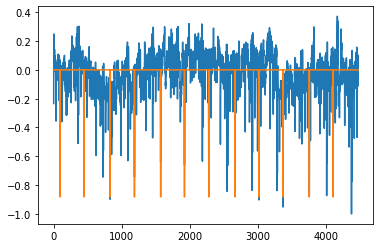

In [58]:
plt.plot(y_train)
plt.plot(y_predict)

In [59]:
y_predict = model.predict(X_test)

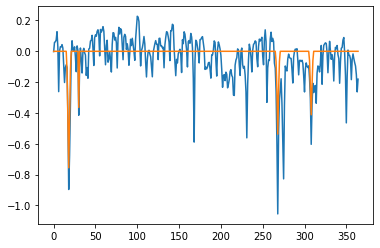

In [299]:
plt.plot(y_test)
plt.plot(y_predict)

In [300]:
ypred = model.predict(X_train)
yforc= model.predict(X_test)
y_new = np.hstack([ypred, yforc])

In [301]:
ynew1 = scaler.inverse_transform(y_new.reshape(-1, 1))

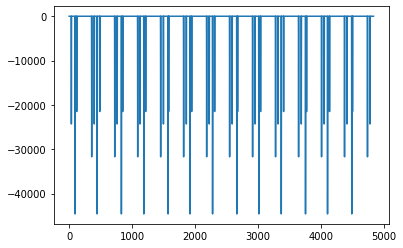

In [302]:
plt.plot(ynew1 + y_res.reshape(-1, 1))

In [244]:
newplot  = pd.concat([yi["predict"] + ynew1.reshape(-1), yi["real"]], axis = 1)

In [249]:
mp = mape_comp(newplot)
newplot[["real", "predict"]].iplot(title = f"MAPE: {mp:.2f}")

In [256]:
path_to_model = Path().resolve().parents[1] / "Models" / "GRegressor" / "GR_model_GR_Xtime_dayear_seasondiff-p1000-100it-mae.pkl"
with open(path_to_model, "wb") as f:
    pickle.dump(model, f)